# Old


Largest triangle vertices:
Vertex 1: [ -67.11941164 -166.2433296 ]
Vertex 2: [  78.82242667 -117.07727585]
Vertex 3: [-36.85254503 153.83952047]
Max area: 22612.688581022645
13
[[ -67.11941164 -166.2433296 ]
 [  78.82242667 -117.07727585]
 [ -36.85254503  153.83952047]]


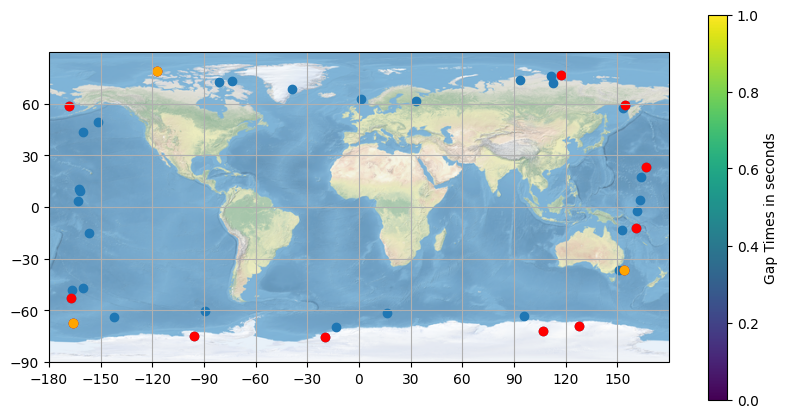

In [47]:

from scipy.spatial import ConvexHull
from itertools import combinations
import numpy as np

from shapely.geometry import Point, Polygon

def points_in_triangle_shapely(gs_list, comb):
    for p in gs_list:
        triangle = Polygon(comb)
        point = Point(p)
        if triangle.contains(point) or triangle.touches(point):
            return True
    return False


# try out 40 different starting points 
lats = np.concatenate([np.random.uniform(-80, -60, 10),
                       np.random.uniform(60, 80, 10),
                       np.random.uniform(-60, 60, 10),
                       np.random.uniform(-60, 60, 10)])

lons = np.concatenate([np.random.uniform(-170, 170, 10),
                       np.random.uniform(-170, 170, 10),
                       np.random.uniform(-170, -150, 10),
                       np.random.uniform(150, 170, 10)])


# Stack latitudes and longitudes together
all_points = np.column_stack([lats, lons])

# Step 2: Calculate the area of triangles formed by each combination of 3 points
def triangle_area(p1, p2, p3):
    # Shoelace formula to calculate area of triangle
    return abs(p1[0]*(p2[1] - p3[1]) + p2[0]*(p3[1] - p1[1]) + p3[0]*(p1[1] - p2[1])) / 2


# Step 3: Find the triangle with the largest area
max_area = 0
best_triangle = None

gs_list = []
# Generate all combinations of 3 points on the convex hull
for comb in combinations(all_points, 3):
    if not points_in_triangle_shapely(gs_list, comb):
        area = triangle_area(comb[0], comb[1], comb[2])
        if area > max_area:
            max_area = area
            best_triangle = np.array([comb[0], comb[1], comb[2]])


# Step 4: Print the result
print("Largest triangle vertices:")
for i, pt in enumerate(best_triangle):
    print(f"Vertex {i+1}: {pt}")
print(f"Max area: {max_area}")


hull = ConvexHull(all_points)
hull_points = all_points[hull.vertices]
print(len(hull_points))
# Display the points
# print(all_points)
print(best_triangle)
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

# Create the figure
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.grid(True)
ax.set_global()
ax.stock_img()
c = 'b' # Set the plot color

# gs_list = [[92.44410570135645, -90.0], [-73.01224079830891, -89.95426045890125], [-4.078723407808447, -89.95514937821778], [-20.501266626711264, -89.91355093899406], [-159.10268897441438, -89.95438003369789], [-115.71665466969782, -89.93402443627843], [-48.87503465712989, -89.90572106322753], [-180.0, -89.91518762080831], [-149.7087766419795, -89.91006098768894], [-77.3218705116782, -89.90973730577142]]
ax.set_yticks(np.arange(-90, 90, 30))
ax.set_xticks(np.arange(-180, 180, 30))

# longs = [gs[0] for gs in gs_list]
# lats = [gs[1] for gs in gs_list]
# sc = ax.scatter(x=longs, y=lats, c=gaps,cmap = 'cool')
sc = ax.scatter(x = all_points[:,1],y = all_points[:,0])
sc = ax.scatter(x = hull_points[:,1],y = hull_points[:,0], c="red")
for coords in best_triangle:
    sc = ax.scatter(x = coords[1],y = coords[0],c = "orange")
cbar = fig.colorbar(sc)
cbar.set_label('Gap Times in seconds')



In [ ]:
import numpy as np
from shapely.geometry import MultiPoint
from itertools import combinations
from pyproj import Geod

# Initialize geodetic calculator
geod = Geod(ellps="WGS84")

# Define bounds (lat_min, lat_max, lon_min, lon_max)
bounds = (36.5, 38.5, -123.0, -121.0)  # Example: SF Bay Area
step_deg = 0.1  # Grid resolution
exclusion_radius_m = 10000  # 10 km
existing_points = [(37.2, -122.1), (37.4, -121.8)]

# Generate grid
def create_candidate_grid(bounds, step_deg):
    lat_min, lat_max, lon_min, lon_max = bounds
    lats = np.arange(lat_min, lat_max, step_deg)
    lons = np.arange(lon_min, lon_max, step_deg)
    return [(lat, lon) for lat in lats for lon in lons]

# Filter out points too close to existing points
def mask_points(grid, existing, radius_m):
    def haversine(lat1, lon1, lat2, lon2):
        _, _, dist = geod.inv(lon1, lat1, lon2, lat2)
        return dist
    return [
        (lat, lon)
        for (lat, lon) in grid
        if all(haversine(lat, lon, qlat, qlon) > radius_m for qlat, qlon in existing)
    ]

# Area of triangle using geodesic method
def triangle_area(p1, p2, p3):
    lons = [p1[1], p2[1], p3[1], p1[1]]
    lats = [p1[0], p2[0], p3[0], p1[0]]
    area, _ = geod.polygon_area_perimeter(lons, lats)
    return abs(area)

# Find triangle on convex hull with max area
def find_largest_triangle_on_hull(points):
    if len(points) < 3:
        return None
    hull = MultiPoint(points).convex_hull
    coords = list(hull.exterior.coords)[:-1]  # drop closing point
    if len(coords) < 3:
        return None
    max_area = -1
    best = None
    for c1, c2, c3 in combinations(coords, 3):
        tri = [(c1[1], c1[0]), (c2[1], c2[0]), (c3[1], c3[0])]  # convert (lon, lat) → (lat, lon)
        area = triangle_area(*tri)
        if area > max_area:
            best = tri
            max_area = area
    return best

# Run pipeline
grid = create_candidate_grid(bounds, step_deg)
valid_points = mask_points(grid, existing_points, exclusion_radius_m)
simplex = find_largest_triangle_on_hull(valid_points)

print(valid_points)
print("Best triangle (simplex):")
for i, pt in enumerate(simplex):
    print(f"Vertex {i+1}: lat = {pt[0]:.6f}, lon = {pt[1]:.6f}")


[(36.5, -123.0), (36.5, -122.9), (36.5, -122.80000000000001), (36.5, -122.70000000000002), (36.5, -122.60000000000002), (36.5, -122.50000000000003), (36.5, -122.40000000000003), (36.5, -122.30000000000004), (36.5, -122.20000000000005), (36.5, -122.10000000000005), (36.5, -122.00000000000006), (36.5, -121.90000000000006), (36.5, -121.80000000000007), (36.5, -121.70000000000007), (36.5, -121.60000000000008), (36.5, -121.50000000000009), (36.5, -121.40000000000009), (36.5, -121.3000000000001), (36.5, -121.2000000000001), (36.5, -121.10000000000011), (36.6, -123.0), (36.6, -122.9), (36.6, -122.80000000000001), (36.6, -122.70000000000002), (36.6, -122.60000000000002), (36.6, -122.50000000000003), (36.6, -122.40000000000003), (36.6, -122.30000000000004), (36.6, -122.20000000000005), (36.6, -122.10000000000005), (36.6, -122.00000000000006), (36.6, -121.90000000000006), (36.6, -121.80000000000007), (36.6, -121.70000000000007), (36.6, -121.60000000000008), (36.6, -121.50000000000009), (36.6, -1

TypeError: 'NoneType' object is not iterable

# simplex 1

In [31]:
points1 =np.array([[ -67.22020118, -130.74024521], [-50.41882936, 151.1907154 ], [ 67.13295708, 103.37276525], [  68.72207478, -141.06484884]])

points2 = np.array([[ -61.63850798, -153.8989432 ], [  69.88846547, -141.823865  ], [ 57.15870844, 140.8070957 ], [-22.39207168, 146.31131705]])
points3 = np.array([[ 69.76522246, -94.38394138], [ -48.74485322, -156.93843321], [-21.42538863, 146.35931037], [ 44.50260863, 157.61848763]])
points4 = np.array([[  64.30255778, -111.59635999], [   4.43224362, -150.7436265 ], [-44.95437952, 153.19479871], [ 48.16625177, 145.48216082]])
points5 = np.array([[  66.04176355, -134.3223051 ], [ -26.51770467, -143.79336359], [-32.45117284, 159.30404681], [ 36.81978758, 153.71264302]])
points10 = np.array([[-68.72773371, -74.88185943], [  68.93041565, -120.43663315], [ 68.63313373, 128.61164844], [-12.88432726, 154.78793455]])
gs_list = np.array([
    [
      -34.70289229627505,
      83.61782014035667
    ],
    [
      -124.47013128577557,
      63.81141217342883
    ],
    [
      -28.70268917253056,
      -89.78155649083521
    ],
    [
      -143.44726450971916,
      -17.458058040307716
    ],
    [
      116.48357625497006,
      -35.01664093398622
    ],
    [
      128.98438036453564,
      69.3142742492614
    ],
    [
      -119.6574642543752,
      36.99916752397816
    ],
    [
      -178.84580109612108,
      -18.217597317872443
    ],
    [
      -68.9254720944049,
      57.70360107739306
    ],
    [
      163.024493500782,
      5.37250161390107
    ]
  ])

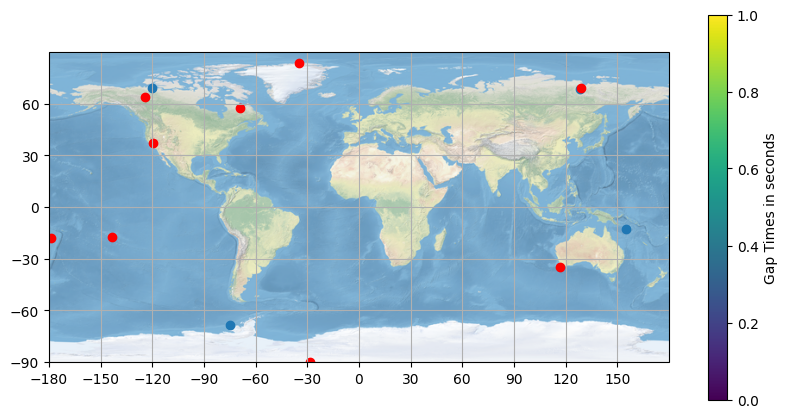

In [32]:

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

# Create the figure
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.grid(True)
ax.set_global()
ax.stock_img()
c = 'b' # Set the plot color

# gs_list = [[92.44410570135645, -90.0], [-73.01224079830891, -89.95426045890125], [-4.078723407808447, -89.95514937821778], [-20.501266626711264, -89.91355093899406], [-159.10268897441438, -89.95438003369789], [-115.71665466969782, -89.93402443627843], [-48.87503465712989, -89.90572106322753], [-180.0, -89.91518762080831], [-149.7087766419795, -89.91006098768894], [-77.3218705116782, -89.90973730577142]]
ax.set_yticks(np.arange(-90, 90, 30))
ax.set_xticks(np.arange(-180, 180, 30))

# longs = [gs[0] for gs in gs_list]
# lats = [gs[1] for gs in gs_list]
# sc = ax.scatter(x=longs, y=lats, c=gaps,cmap = 'cool')
sc = ax.scatter(x = points10[:,1],y = points10[:,0])
sc = ax.scatter(y = gs_list[0:9,1],x = gs_list[0:9,0], c="red")
# for coords in best_triangle:
#     sc = ax.scatter(x = coords[1],y = coords[0],c = "orange")
cbar = fig.colorbar(sc)
cbar.set_label('Gap Times in seconds')


In [ ]:

(array([ -61.63850798, -153.8989432 ]), array([  69.88846547, -141.823865  ]), array([ 57.15870844, 140.8070957 ]), array([-22.39207168, 146.31131705]))
(array([ 69.76522246, -94.38394138]), array([ -48.74485322, -156.93843321]), array([-21.42538863, 146.35931037]), array([ 44.50260863, 157.61848763]))
(array([  64.30255778, -111.59635999]), array([   4.43224362, -150.7436265 ]), array([-44.95437952, 153.19479871]), array([ 48.16625177, 145.48216082]))
(array([  66.04176355, -134.3223051 ]), array([ -26.51770467, -143.79336359]), array([-32.45117284, 159.30404681]), array([ 36.81978758, 153.71264302]))

NameError: name 'array' is not defined

# New

## Setup Imports

(not relevant to repo, can skip) 

Adding module path to run correctly in examples folder

In [1]:
import sys
import os

# Add the path to the folder containing the module
module_path = os.path.abspath(os.path.join('../..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

/Users/gracekim/Documents/School_Everything_and_LEARNING/Stanford/Githubs/loc-gsopt/src


In [2]:
# from common.objective_functions import penalty_gs_all
from methods.free_select.scipy_ccgs import simplex_select


In [3]:

initial_simplex = simplex_select([],False)

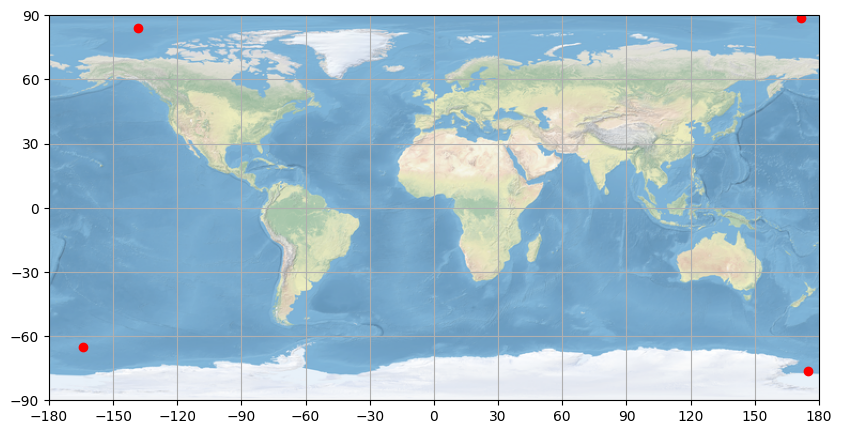

In [6]:

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Create the figure
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.grid(True)
ax.set_global()
ax.stock_img()

ax.set_yticks(np.arange(-90, 91, 30))
ax.set_xticks(np.arange(-180, 181, 30))

simplex = np.array([[ -76.37124953,  174.81031738],
       [  88.91243954,  171.72569881],
       [  83.8585232 , -138.48187088],
       [ -64.93288628, -163.90913185]])
ax.scatter(simplex[:, 1], simplex[:, 0], c = "red", transform=ccrs.PlateCarree())

# ax.scatter(y = simplex[:,1],x = simplex[:,0], c="red",transform=ccrs.PlateCarree())
plt.show()


In [7]:
simplex

array([[ -76.37124953,  174.81031738],
       [  88.91243954,  171.72569881],
       [  83.8585232 , -138.48187088],
       [ -64.93288628, -163.90913185]])

In [8]:
import numpy as np
# from numba import njit

# @njit(fastmath=True)
def haversine_numba(lat1, lon1, lat2, lon2):
    R = 6371.0
    phi1, phi2 = np.deg2rad(lat1), np.deg2rad(lat2)
    dphi  = np.deg2rad(lat2 - lat1)
    dlamb = np.deg2rad(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlamb/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def farthest_four(points):
    """Greedy k‑centre: select 4 widely‑spaced points from `points` (N×2)."""
    N = len(points)
    chosen = [np.random.randint(N)]          # 1st point random
    dists  = np.full(N, np.inf)

    for _ in range(3):                      # need total of 4
        # update min distance to current set
        for i in range(N):
            for j in chosen[-1:]:
                d = haversine_numba(points[i,0], points[i,1],
                                     points[j,0], points[j,1])
                if d < dists[i]:
                    dists[i] = d
        chosen.append(int(np.argmax(dists))) # pick farthest

    return points[chosen]

# --- driver -------------------------------------------------
def simplex_select(n_samples=120):
    lats = np.degrees(np.arcsin(np.random.uniform(-1, 1, n_samples)))
    lons = np.random.uniform(-180, 180, n_samples)
    pts  = np.column_stack((lats, lons))
    return farthest_four(pts)

best_simplex = simplex_select()


Selected 4 furthest points:
[[ -1.13833018 -67.5799528 ]
 [ -3.43532393 117.48056213]
 [ 61.29346218  29.41385289]
 [-32.86175679  25.0896601 ]]


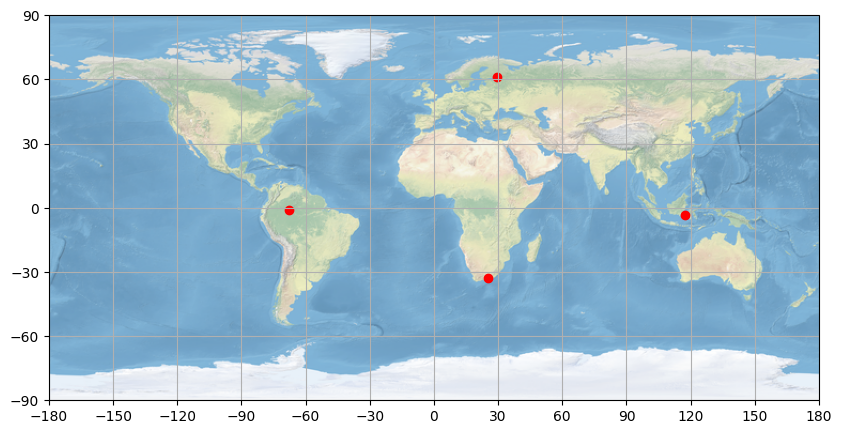

In [17]:

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Create the figure
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.grid(True)
ax.set_global()
ax.stock_img()

ax.set_yticks(np.arange(-90, 91, 30))
ax.set_xticks(np.arange(-180, 181, 30))

simplex = simplex_select(n_samples=200)
print("Selected 4 furthest points:")
print(simplex)

ax.scatter(simplex[:, 1], simplex[:, 0], c = "red", transform=ccrs.PlateCarree())

# ax.scatter(y = simplex[:,1],x = simplex[:,0], c="red",transform=ccrs.PlateCarree())
plt.show()
